<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/customer_service_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
%%capture --no-stderr
%pip install langchain_google_genai langchain_core langchain_community langgraph tavily-python

In [46]:
from google.colab import userdata
GOOGLE_API_KEY= userdata.get('GOOGLE_API_KEY')
Tavily_Api_Key= userdata.get('Tavily_Api_Key')
import os
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["langchain"] = userdata.get("langchain")
os.environ["Tavily_Api_Key"] = userdata.get("Tavily_Api_Key")


In [47]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GOOGLE_API_KEY)
llm.invoke("assalamualyum , i m hafiz naveed uddin , how r u?")


AIMessage(content='Assalamu alaykum Hafiz Naveed Uddin!  I am doing well, thank you for asking. How are you?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-1cd80e41-a2c6-4d15-b817-9af99c0bc935-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})

In [48]:
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata
import os

# Get Tavily API key from userdata
tavily_api_key = userdata.get('Tavily_Api_Key')

# Option 1: Set environment variable (recommended for security)
os.environ["TAVILY_API_KEY"] = tavily_api_key  # Set the env variable explicitly

# Option 2: Pass API key directly (less secure)
# tool = TavilySearchResults(tavily_api_key=tavily_api_key, max_results=2)

# Initialize the tool after setting the env variable
tool = TavilySearchResults(max_results=2)

# Use the tool
tools = [tool]
tool.invoke("What is AI agent?")

[{'url': 'https://theconversation.com/what-is-an-ai-agent-a-computer-scientist-explains-the-next-wave-of-artificial-intelligence-tools-242586',
  'content': 'What is an AI agent? What is an AI agent? As a computer scientist, I offer this definition: AI agents are technological tools that can learn a lot about a given environment, and then – with a few simple prompts from a human – work to solve problems or perform specific tasks in that environment. Many of today’s AI agents are utility based, meaning they give more consideration to how to achieve their goals. Researchers at OpenAI and Google DeepMind say agents are another step on the path to artificial general intelligence or “strong” AI – that is, AI that exceeds human capabilities in a wide variety of domains and tasks.'},
 {'url': 'https://techcrunch.com/2024/12/15/what-exactly-is-an-ai-agent/',
  'content': 'At its simplest, an AI agent is best described as AI-fueled software that does a series of jobs for you that a human custom

In [54]:
def billing_tool(query: str) -> str:
    """
    Handles billing-related queries.
    """
    return "Billing Department: Your query about billing is being processed. Please wait."

def product_tool(query: str) -> str:
    """
    Provides product-related information.
    """
    return "Product Inquiry: I have forwarded your question about the product details."

def technical_tool(query: str) -> str:
    """
    Offers basic technical support advice.
    """
    return "Technical Support: Please restart the device and try again. If the issue persists, contact support."

def feedback_tool(query: str) -> str:
    """
    Collects user feedback.
    """
    return "Thank you for your feedback! Your input helps us improve."

def account_tool(query: str) -> str:
    """
    Manages account-related queries.
    """
    return "Account Management: Please provide your registered email to proceed with account-related queries."

# Enhanced Tools for Extended Services

def order_status_tool(order_id: str) -> str:
    """
    Tracks the order status based on the provided order ID.
    """
    return f"Order Status: Your order with ID {order_id} is currently being processed. Please check back later for updates."

def customer_greeting_tool() -> str:
    """
    Greets the customer and sets a friendly tone.
    """
    return "Hello! How can I assist you today? We are here to help you with billing, product inquiries, technical issues, or account management."

# System Message
sys_msg = "You are a highly capable customer service agent. Your role is to assist users by answering their queries promptly, resolving issues, and directing complex questions to appropriate tools. Respond in a friendly and professional manner."

# Combine Tools into a List
tools = [
    billing_tool,product_tool,
    technical_tool,
    feedback_tool,
    account_tool,
    order_status_tool,
    customer_greeting_tool,
]

# Bind Tools to LLM
llm_with_tools = llm.bind_tools(tools)


In [55]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b573d9dd9f0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'billing_tool', 'description': 'Handles billing-related queries.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'product_tool', 'description': 'Provides product-related information.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'technical_tool', 'description': 'Offers basic technical support advice.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'feedback_tool', '

In [56]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

In [57]:
sys_msg = SystemMessage(content=(
    "You are a knowledgeable customer service assistant specializing in resolving queries related to "
    "Billing, Product Information, Technical Support, Feedback Collection, and Account Management. "
    "Your responses should always be accurate, empathetic, and polite. When unsure, suggest connecting to a human assistant."
))
# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

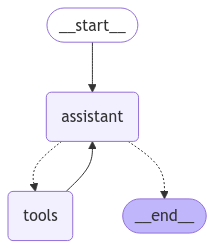

In [58]:
# Graph
builder: StateGraph = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # Now tools is a list of BaseTool objects

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",

    tools_condition,
)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [59]:
config1 = {"configurable": {"thread_id": "1"}}


messages = graph.invoke({"messages": [HumanMessage(content="ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?


In [60]:
messages = graph.invoke({"messages": [HumanMessage(content="I made a payment, but it’s not reflected in my billing statement. What should I do?")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.


In [61]:
messages = graph.invoke({"messages": [HumanMessage(content="Yes, my order ID is #12345. Can you check the payment status for me?")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.
================================ Human Message ====

In [62]:
messages = graph.invoke({"messages": [HumanMessage(content="Can I cancel my order if it’s still being processed?")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.
================================ Human Message ====

In [63]:
messages = graph.invoke({"messages": [HumanMessage(content="YES SURE  THIS IS MY EMAIL ADDRESS ,'HNAVEED264@GMAIL.COM' ")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.
================================ Human Message ====

In [64]:
messages = graph.invoke({"messages": [HumanMessage(content="This is a very confusing matter. Okay, I'm not canceling my order, but please try to ensure that my order is delivered by tomorrow.")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.
================================ Human Message ====

In [65]:
messages = graph.invoke({"messages": [HumanMessage(content=" THIS IS MY COMPLETE SHIPPING ADDRESS 'HOUSE NO.2 PIAIC KARACHI ' AND Thank you for prioritizing my order. Can you confirm if it will arrive tomorrow, or provide a tracking number for real-time updates?")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED FROM KARACHI
================================== Ai Message ==================================

Wa Alaikum Assalam Hafiz Naveed!  It's a pleasure to meet you. How can I assist you today?
================================ Human Message =================================

I made a payment, but it’s not reflected in my billing statement. What should I do?
================================== Ai Message ==================================

I understand that your payment isn't showing up on your billing statement, and that's frustrating. Let's get this sorted out for you.  Could you please provide me with your order ID or the date of the payment?  This will help me quickly investigate the issue using our billing tools.  If you don't have that information readily available,  providing your account email address would also be helpful.
================================ Human Message ====

# ***`MY 2ND THREAD ID "2"`***

In [66]:
config2 = {"configurable": {"thread_id": "2"}}


messages = graph.invoke({"messages": [HumanMessage(content="ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?


In [67]:
messages = graph.invoke({"messages": [HumanMessage(content="I need help accessing my account. I’ve forgotten my password and can’t log in.")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?
================================ Human Message =================================

I need help accessing my account. I’ve forgotten my password and can’t log in.
================================== Ai Message ==================================

I understand that you're having trouble accessing your account because you've forgotten your password.  That's frustrating, I'm sorry about that.

To help you regain access, I'll need to collect some information to verify your identity.  Could you please provide me with the email address or username associated with your account?  Once verified, I can guide you through the password reset process.

If you are having trouble remembering your username or email address, providing

In [68]:
messages = graph.invoke({"messages": [HumanMessage(content="My email address is FATMA123@GMAIL.COM. Can you send the password reset instructions?")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?
================================ Human Message =================================

I need help accessing my account. I’ve forgotten my password and can’t log in.
================================== Ai Message ==================================

I understand that you're having trouble accessing your account because you've forgotten your password.  That's frustrating, I'm sorry about that.

To help you regain access, I'll need to collect some information to verify your identity.  Could you please provide me with the email address or username associated with your account?  Once verified, I can guide you through the password reset process.

If you are having trouble remembering your username or email address, providing

In [69]:
messages = graph.invoke({"messages": [HumanMessage(content="I visited the password recovery page, but I didn't receive the reset email even though I entered my email address correctly. What should I do now?")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?
================================ Human Message =================================

I need help accessing my account. I’ve forgotten my password and can’t log in.
================================== Ai Message ==================================

I understand that you're having trouble accessing your account because you've forgotten your password.  That's frustrating, I'm sorry about that.

To help you regain access, I'll need to collect some information to verify your identity.  Could you please provide me with the email address or username associated with your account?  Once verified, I can guide you through the password reset process.

If you are having trouble remembering your username or email address, providing

In [70]:
messages = graph.invoke({"messages": [HumanMessage(content="I've tried checking my spam folder, re-entering my email (FATMA123@GMAIL.COM), and waiting for 20 minutes, but I still haven't received the reset email. Can you escalate this issue to the technical team or suggest another solution?")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?
================================ Human Message =================================

I need help accessing my account. I’ve forgotten my password and can’t log in.
================================== Ai Message ==================================

I understand that you're having trouble accessing your account because you've forgotten your password.  That's frustrating, I'm sorry about that.

To help you regain access, I'll need to collect some information to verify your identity.  Could you please provide me with the email address or username associated with your account?  Once verified, I can guide you through the password reset process.

If you are having trouble remembering your username or email address, providing

In [71]:
messages = graph.invoke({"messages": [HumanMessage(content="OK ALLAH HAFIZ")]},config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM FATIMA ZEHRA D/O HAFIZ NAVEED UDDIN
================================== Ai Message ==================================

Assalamu Alaikum Fatima Zehra!  How can I help you today?
================================ Human Message =================================

I need help accessing my account. I’ve forgotten my password and can’t log in.
================================== Ai Message ==================================

I understand that you're having trouble accessing your account because you've forgotten your password.  That's frustrating, I'm sorry about that.

To help you regain access, I'll need to collect some information to verify your identity.  Could you please provide me with the email address or username associated with your account?  Once verified, I can guide you through the password reset process.

If you are having trouble remembering your username or email address, providing

In [76]:
config4 = {"configurable": {"thread_id": "4"}}


messages = graph.invoke({"messages": [HumanMessage(content="ASSALUMUALYKUM , IM HAFIZ NAVEED ,I forgot my account password. How can I reset it?")]},config4)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED ,I forgot my account password. How can I reset it?
================================== Ai Message ==================================

Assalamu Alaikum Hafiz Naveed,

I understand you've forgotten your account password.  I can certainly help you with that. To reset your password, could you please tell me the email address or username associated with your account?  Once you provide that information, I can guide you through the password reset process.


In [77]:
config4 = {"configurable": {"thread_id": "4"}}


messages = graph.invoke({"messages": [HumanMessage(content="ok sure,  this is my email address : 'hnaveed264@gmailcom',")]},config4)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED ,I forgot my account password. How can I reset it?
================================== Ai Message ==================================

Assalamu Alaikum Hafiz Naveed,

I understand you've forgotten your account password.  I can certainly help you with that. To reset your password, could you please tell me the email address or username associated with your account?  Once you provide that information, I can guide you through the password reset process.
================================ Human Message =================================

ok sure,  this is my email address : 'hnaveed264@gmailcom',
================================== Ai Message ==================================

Thank you for providing your email address, Hafiz Naveed.  I'm now going to access the account recovery tools.  Please allow me a moment.
Tool Calls:
  account_tool (9157d819-868e-4a7e-8f40-f06fa249dba4)
 Call

In [78]:
messages = graph.invoke({"messages": [HumanMessage(content="yes i received email and have done reset pasword ")]},config4)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALUMUALYKUM , IM HAFIZ NAVEED ,I forgot my account password. How can I reset it?
================================== Ai Message ==================================

Assalamu Alaikum Hafiz Naveed,

I understand you've forgotten your account password.  I can certainly help you with that. To reset your password, could you please tell me the email address or username associated with your account?  Once you provide that information, I can guide you through the password reset process.
================================ Human Message =================================

ok sure,  this is my email address : 'hnaveed264@gmailcom',
================================== Ai Message ==================================

Thank you for providing your email address, Hafiz Naveed.  I'm now going to access the account recovery tools.  Please allow me a moment.
Tool Calls:
  account_tool (9157d819-868e-4a7e-8f40-f06fa249dba4)
 Call

In [79]:
config5 = {"configurable": {"thread_id": "5"}}


messages = graph.invoke({"messages": [HumanMessage(content="assalamualykum this is naveed , i have some emergency plz help")]},config5)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

assalamualykum this is naveed , i have some emergency plz help
================================== Ai Message ==================================

Assalamualykum Naveed, I understand you're in an emergency and need help.  To assist you effectively, could you please describe your issue?  Knowing the nature of your emergency will help me direct you to the appropriate resources or connect you with a human assistant who can provide immediate support.


In [80]:
messages = graph.invoke({"messages": [HumanMessage(content="My MCB ATM card is not working.")]},config5)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

assalamualykum this is naveed , i have some emergency plz help
================================== Ai Message ==================================

Assalamualykum Naveed, I understand you're in an emergency and need help.  To assist you effectively, could you please describe your issue?  Knowing the nature of your emergency will help me direct you to the appropriate resources or connect you with a human assistant who can provide immediate support.
================================ Human Message =================================

My MCB ATM card is not working.
================================== Ai Message ==================================

Assalamualykum Naveed, I'm sorry to hear that your MCB ATM card isn't working. This can be frustrating.  To help me troubleshoot this, could you please tell me:

* **What exactly is happening?** (e.g.,  Is it being declined?  Is it showing an error message? Is it physicall

In [81]:
messages = graph.invoke({"messages": [HumanMessage(content="I Dont't know exactly issue but I went to withdraw money from the ATM, but my card is not working. this is my card number : '12344321 'Please assist.")]},config5)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

assalamualykum this is naveed , i have some emergency plz help
================================== Ai Message ==================================

Assalamualykum Naveed, I understand you're in an emergency and need help.  To assist you effectively, could you please describe your issue?  Knowing the nature of your emergency will help me direct you to the appropriate resources or connect you with a human assistant who can provide immediate support.
================================ Human Message =================================

My MCB ATM card is not working.
================================== Ai Message ==================================

Assalamualykum Naveed, I'm sorry to hear that your MCB ATM card isn't working. This can be frustrating.  To help me troubleshoot this, could you please tell me:

* **What exactly is happening?** (e.g.,  Is it being declined?  Is it showing an error message? Is it physicall

In [83]:
messages = graph.invoke({"messages": [HumanMessage(content="Thank you for your advice. I understand the security concerns. I will contact MCB's customer service hotline directly to resolve the issue with my ATM card. Appreciate your assistance.")]}, config5)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

assalamualykum this is naveed , i have some emergency plz help
================================== Ai Message ==================================

Assalamualykum Naveed, I understand you're in an emergency and need help.  To assist you effectively, could you please describe your issue?  Knowing the nature of your emergency will help me direct you to the appropriate resources or connect you with a human assistant who can provide immediate support.
================================ Human Message =================================

My MCB ATM card is not working.
================================== Ai Message ==================================

Assalamualykum Naveed, I'm sorry to hear that your MCB ATM card isn't working. This can be frustrating.  To help me troubleshoot this, could you please tell me:

* **What exactly is happening?** (e.g.,  Is it being declined?  Is it showing an error message? Is it physicall